In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import sklearn as sklearn
from sklearn import decomposition,cluster
import re
import statsmodels.api as sm
#import geoplot as gplt
#import geopandas as gpd

def refresh_dico(Name,Code,df):
    dic = {}
    for i in df[[Name,Code]].dropna().drop_duplicates().iterrows() :
        dic[i[1][Name]] = i[1][Code]
    return (dic)

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    gdf = gdf.reset_index()
    gdf = gdf.set_index('Pays_indic')
    return(gdf)

def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64))/np.log10(df_norm.astype(np.float64).max()))

def geo_plot (df,indic,annee,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            print(i +' n\'a aucun équivalent dans la table des données')
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    if norm :
        gdf[annee] = log_norm(gdf[annee])
    gplt.choropleth(gdf,
                hue = annee,
                cmap = couleur,
                #norm=colors.LogNorm(vmin=gdf[annee].min(),
                #                    vmax=gdf[annee].max()),
                legend=True,
                ax=ax)
    plt.show()

In [153]:
df1 = pd.read_csv("Complete_Data.csv")
df1 = df1.set_index('Pays_indic')
dic_code = refresh_dico('Country Code','Country Name',df1)

On crée ici une liste des codes de pays, et un dictionnaire avec le nom des variables

In [154]:
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

dic = {}
dic['pib'] = '_GDP (current US$)'
dic['pib_hab'] = '_GDP (current US$) par Tete'
dic['pib_growth'] = '_GDP growth (annual %)'
dic['pib_hab_growth'] = '_Croissance_GDP (current US$) par Tete (pourcent)'
dic['pop'] = '_Population, total'
dic['ges'] = '_Émissions totales de GES (kt d’équivalent CO2)'
dic['ges_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) (pourcent)	'
dic['ges_hab'] = '_Émissions totales de GES (kt d’équivalent CO2) par Tete'
dic['ges_hab_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)'
dic['industry'] = '_Industry (including construction), value added (% of GDP)'
dic['agr'] = '_Agriculture, forestry, and fishing, value added (% of GDP)'
dic['clean_nrj'] = '_Alternative and nuclear energy (% of total energy use)'
dic['nrj_hab'] = '_Energy use (kg of oil equivalent per capita)'
dic['nrj_hab_growth'] = '_Croissance_Energy use (kg of oil equivalent per capita) (pourcent)'

On va chercher à créer la base avec les données qui nous intéressent pour la modélisation

In [155]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            coef = results.params[1]

            return coef, r2
    
    else : return
    
def get_coeff (regresse, regresseur) :    
    dico = {}
    for code in code_list:
        dico[code] = regress(code, regresse, regresseur)
        if dico[code] == None:
            dico.pop(code)

    regress_df = pd.DataFrame(dico.values(), dico.keys(), ['Coefficient de ' + regresse + ' sur ' + regresseur,
                                                         'R2 de ' + regresse + ' sur ' + regresseur])
    return regress_df


def get_2000(var):
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :
            dic[country_code] = df1.loc[country_code + var][23]
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['2000' + var])
    
    return(temp_df)

def get_average_growth_rate(var) :
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :    
            values = list(df1.loc[country_code + var][3:])
            values = [x for x in values if ~np.isnan(x)]
            initial_value = values[0]
            final_value = values[len(values)-1]
            variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100
            if variation_rate != np.inf :
                dic[country_code] = variation_rate
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['Average Growth Rate' + var])
    
    return(temp_df)

In [162]:
data = get_average_growth_rate(dic['pib_hab'])

data_list = [get_average_growth_rate(dic['agr']), get_average_growth_rate(dic['industry']), 
            get_average_growth_rate(dic['ges_hab']), get_average_growth_rate(dic['clean_nrj']),
            get_average_growth_rate(dic['nrj_hab']), 
            get_2000(dic['pib_hab']), get_2000(dic['agr']), get_2000(dic['industry']),
            get_2000(dic['ges_hab']), get_2000(dic['clean_nrj']), get_2000(dic['nrj_hab']), 
            get_coeff(dic['pib_hab'], dic['ges_hab']), get_coeff(dic['pib_hab_growth'], dic['ges_hab_growth']),
            get_coeff(dic['pib_hab'], dic['nrj_hab']), get_coeff(dic['pib_hab_growth'], dic['nrj_hab_growth'])]
for i in data_list :
    data = data.merge(i, how = 'outer', left_index = True, right_index = True)


<ipython-input-155-4bd91c805f1f>:53: RuntimeWarning: divide by zero encountered in double_scalars
  variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100
<ipython-input-155-4bd91c805f1f>:53: RuntimeWarning: invalid value encountered in double_scalars
  variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100


In [235]:
def get_cluster_ACP(n_k_means, data, graph_ACP=False,to_normalize=True,graph_k_means=False,seed=False):
    #normalisation
    if to_normalize == True :
        data_norm = pd.DataFrame()
        for i in data.columns :
            data_norm[i] = preprocessing.scale(data[i])
            data_norm.index = data.index
    else : 
        data_norm=data
        
    #On crée le graphe du coude des clusters
    if graph_k_means==True:
        iner = []
        for k in range(2,10):
            result=data_norm.copy()
            centroid, appartenance, inertie = sklearn.cluster.k_means(data_norm, k)
            iner.append(inertie)
        plt.plot(np.linspace(2,9,num=8),iner)
        plt.title("Evolution de l'inertie en fonction du nombre de cluster")
        plt.show() 
    
    
    #graph ACP
    if graph_ACP==True:
        
        PCA = sklearn.decomposition.PCA(10)
        PCA.fit(data_norm)

        res = PCA.explained_variance_ratio_

        t=np.linspace(1,10,num=10)
        plt.plot(t,PCA.explained_variance_ratio_*100)
        plt.title("Part de la variance expliquée sur chaque axe de l'ACP")
        plt.show()

    #on enregistre dans la base les centroïdes
    result=data_norm.copy()
    if seed != False:
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means,random_state=seed)
    else :
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means)
    for i in range(0,n_k_means-1):
        result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
    
     
        
    #Application de l'ACP
    PCA = sklearn.decomposition.PCA(2)
    PCA.fit(data_norm)
    data_ds_acp = PCA.transform(data_norm)
    result_ACP = pd.DataFrame(data_ds_acp)
    
    #Enregistrement des données de l'ACP
    data_norm.loc['axis_1']=PCA.components_[0]
    data_norm.loc['axis_2']=PCA.components_[1]
    PCA_axis=data_norm.loc[['axis_1','axis_2']]
    
    #représentation graphique des clusters dans l'ACP
    result_ACP.index = result.index[:-n_k_means+1]
    result_ACP['Cluster'] = result['Cluster'][:-n_k_means+1]
    colormap = np.array(['black','red','royalblue','forestgreen','gold','silver','darkgoldenrod','deeppink','mediumturquoise','orange','firebrick'])
    plt.scatter(result_ACP[0].to_numpy(),result_ACP[1].to_numpy(),c = colormap[result_ACP['Cluster'].astype(int).to_numpy()])
    plt.title("Représentation des clusters dans L'ACP")
    plt.show()
    
    dic_cluster={}
    for i in range (n_k_means):
        dic_cluster['Cluster'+str(i)]=list(result.where(result['Cluster'] == i).dropna().index[:-1])
        dic_cluster['Cluster'+str(i)].append(colormap[i])

        
    return result,dic_cluster,PCA_axis

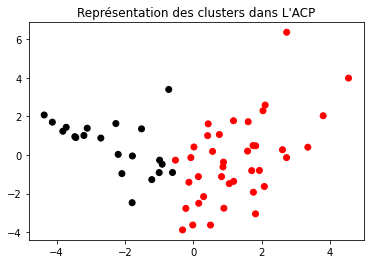

In [147]:
#A,dic,axis=get_cluster_ACP(4,test,graph_ACP=True,graph_k_means=True)
A,dic,axis=get_cluster_ACP(2,test)

In [165]:
data.head(2)


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent)
AGO,3.737056,NaN,NaN,-3.812102,2.444285,-0.013122,556.836318,NaN,NaN,0.002121,0.873405,438.550019,-5.078478e-07,0.310325,0.019271,0.000805,0.011929,0.322442,0.016749,0.015663
ALB,6.258686,NaN,NaN,-1.034237,3.255546,-1.029918,1126.683318,NaN,NaN,0.002716,19.677699,580.494764,2.821586e-08,0.002799,0.214836,0.178441,0.025436,0.047381,0.269240,0.322264


In [167]:
data_2=data.drop(['Average Growth Rate_Alternative and nuclear energy (% of total energy use)','Average Growth Rate_Energy use (kg of oil equivalent per capita)',
                '2000_Energy use (kg of oil equivalent per capita)','2000_Alternative and nuclear energy (% of total energy use)',
                'Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)',
                'R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)',
                'Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent)',
                'R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent)'
               ],axis=1)




In [171]:
data_2=data_2.dropna(axis=0)

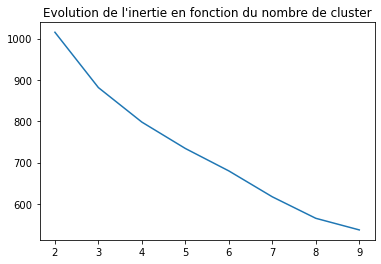

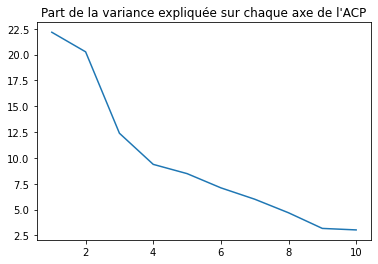

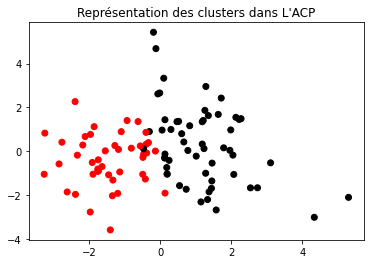

In [173]:
A,dic,axis=get_cluster_ACP(2,data_2,graph_ACP=True,graph_k_means=True)

In [174]:
axis.head()


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)
axis_1,0.391505,-0.404248,-0.164507,0.140130,0.287125,-0.472394,0.180053,0.087451,-0.026185,0.376322,0.160334,0.350618
axis_2,-0.336427,0.134981,-0.274349,-0.450141,0.355884,-0.283178,0.292830,0.381932,-0.289190,-0.209141,0.041360,-0.152174


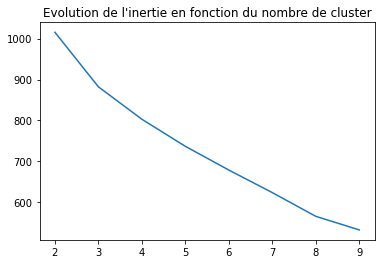

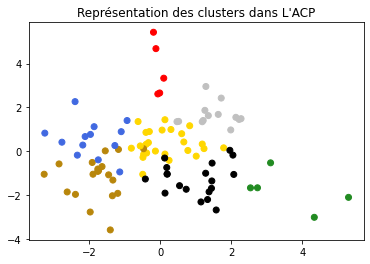

In [250]:
A,dic,axis=get_cluster_ACP(7,data_2,graph_k_means=True,seed=402)

In [251]:
axis.head()

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)
axis_1,0.391505,-0.404248,-0.164507,0.140130,0.287125,-0.472394,0.180053,0.087451,-0.026185,0.376322,0.160334,0.350618
axis_2,-0.336427,0.134981,-0.274349,-0.450141,0.355884,-0.283178,0.292830,0.381932,-0.289190,-0.209141,0.041360,-0.152174


In [252]:
data_set_3=data.drop(['Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)',
                  'Average Growth Rate_Industry (including construction), value added (% of GDP)',
                  '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                  '2000_Industry (including construction), value added (% of GDP)'],axis=1)
data_set_3=data_set_3.dropna()
data_set_3.shape

(79, 16)

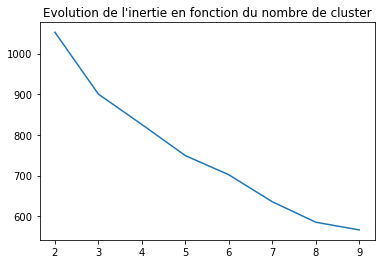

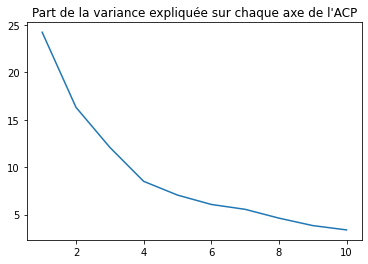

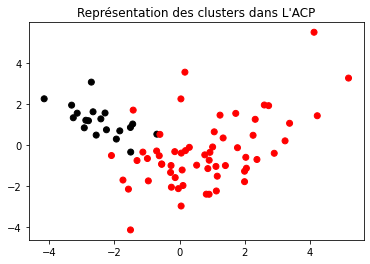

In [256]:
A,dic,axis=get_cluster_ACP(2,data_set_3,graph_k_means=True,graph_ACP=True)

In [257]:
axis.head(2)

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent)
axis_1,0.220360,0.278102,-0.055288,0.365131,-0.340033,-0.272783,-0.247374,-0.313388,0.020635,0.133082,0.165502,0.189970,0.327119,0.371784,0.187917,0.161636
axis_2,0.370627,0.156826,0.226440,0.024756,0.303729,0.108916,0.273914,0.326816,-0.134136,0.259424,0.072764,0.390195,-0.120071,-0.047997,0.327159,0.365524


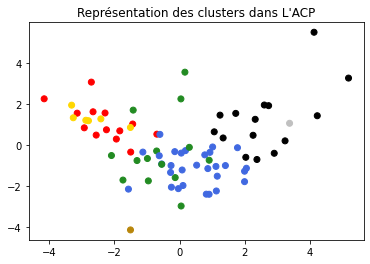

In [294]:
A,dic,axis=get_cluster_ACP(7,data_set_3)

In [302]:
axis.head()

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent)
axis_1,0.220360,0.278102,-0.055288,0.365131,-0.340033,-0.272783,-0.247374,-0.313388,0.020635,0.133082,0.165502,0.189970,0.327119,0.371784,0.187917,0.161636
axis_2,0.370627,0.156826,0.226440,0.024756,0.303729,0.108916,0.273914,0.326816,-0.134136,0.259424,0.072764,0.390195,-0.120071,-0.047997,0.327159,0.365524


In [295]:
dic

{'Cluster0': ['BOL',
  'CHL',
  'CHN',
  'CRI',
  'DOM',
  'IND',
  'KOR',
  'MYS',
  'PRT',
  'SLV',
  'THA',
  'TUN',
  'TUR',
  'URY',
  'VNM',
  'black'],
 'Cluster1': ['AUS',
  'AUT',
  'BEL',
  'CAN',
  'DEU',
  'DNK',
  'FIN',
  'GBR',
  'IRL',
  'LUX',
  'NLD',
  'NZL',
  'USA',
  'red'],
 'Cluster2': ['ARG',
  'BGD',
  'BRA',
  'BWA',
  'DZA',
  'ECU',
  'EGY',
  'ESP',
  'ETH',
  'GAB',
  'GHA',
  'GRC',
  'GTM',
  'HTI',
  'IDN',
  'ITA',
  'JAM',
  'KEN',
  'LKA',
  'MAR',
  'NGA',
  'NIC',
  'NPL',
  'PAK',
  'PAN',
  'PER',
  'SDN',
  'TGO',
  'VEN',
  'royalblue'],
 'Cluster3': ['AGO',
  'ALB',
  'BGR',
  'CIV',
  'CMR',
  'COG',
  'COL',
  'CUB',
  'HND',
  'MEX',
  'PHL',
  'PRY',
  'ROU',
  'ZMB',
  'forestgreen'],
 'Cluster4': ['CHE', 'FRA', 'ISL', 'JPN', 'NOR', 'SWE', 'gold'],
 'Cluster5': ['TZA', 'silver'],
 'Cluster6': ['darkgoldenrod']}

In [301]:
A.loc[['Centroid 0','Centroid 1','Centroid 2','Centroid 3','Centroid 4','Centroid 5']]

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),Cluster
Centroid 0,0.832815,0.972030,0.088625,1.256570,-0.428369,-0.412165,-0.254437,-0.353346,0.126858,0.836032,0.260762,0.663659,0.786084,1.004563,1.162448,0.933565,0.0
Centroid 1,0.095704,-0.312194,0.575636,-0.724968,1.455081,1.246112,0.219188,1.457259,-0.137281,0.110903,-0.184726,-0.285801,-0.674731,-0.635545,-0.139644,-0.298762,1.0
Centroid 2,-0.215510,0.330662,-0.148632,0.107706,-0.487938,-0.304471,-0.442775,-0.490198,-0.012109,-0.245906,-0.111162,-0.324489,0.201267,0.235974,-0.512545,-0.527720,2.0
Centroid 3,-0.315765,-1.031560,-0.077144,-0.794844,-0.614292,-0.250933,-0.088849,-0.539380,-0.520825,-0.701585,-0.224255,0.119865,-0.616684,-0.768124,0.348465,0.699524,3.0
Centroid 4,-0.249662,-0.613669,-0.355355,-0.138676,1.950238,0.255709,2.705536,1.604102,-0.201933,0.731265,-0.209864,-0.282670,-0.280795,-0.551367,-0.684459,-0.685196,4.0
Centroid 5,0.792514,0.280994,-0.411789,-0.355288,-0.721067,-0.289994,-0.674697,-0.727231,0.918158,-0.424671,6.376170,3.855276,1.043242,1.251942,-0.487808,0.269118,5.0


In [304]:
data_set_4=data.drop(['Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)',
                      'Average Growth Rate_Industry (including construction), value added (% of GDP)',
                      '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                      '2000_Industry (including construction), value added (% of GDP)',
                      'Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)',
                      'R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)'],axis=1)
data_set_4=data_set_4.dropna()
data_set_4.shape

(79, 14)

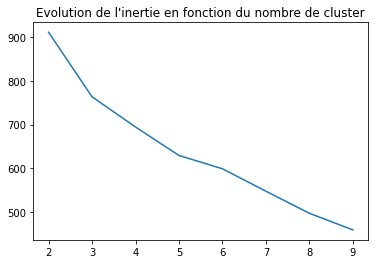

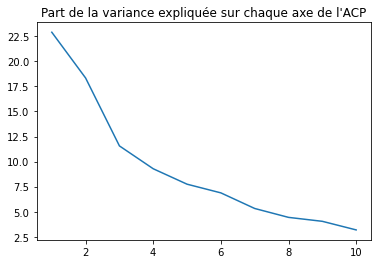

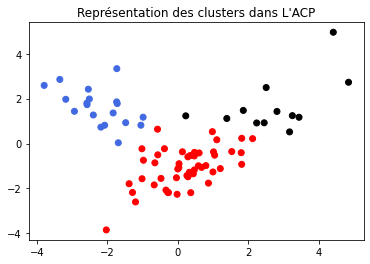

In [305]:
A,dic,axis=get_cluster_ACP(3,data_set_4,graph_ACP=True,graph_k_means=True)

In [306]:
axis.head()

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent),Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent),R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Energy use (kg of oil equivalent per capita) (pourcent)
axis_1,0.291353,0.306155,-0.000139,0.287719,-0.370846,-0.302626,-0.244688,-0.346809,0.002808,0.140968,0.174211,0.311782,0.300626,0.302538
axis_2,0.328280,0.110911,0.219738,0.021126,0.408517,0.180873,0.339412,0.431256,-0.135443,0.262848,0.045071,0.313968,0.254253,0.278804


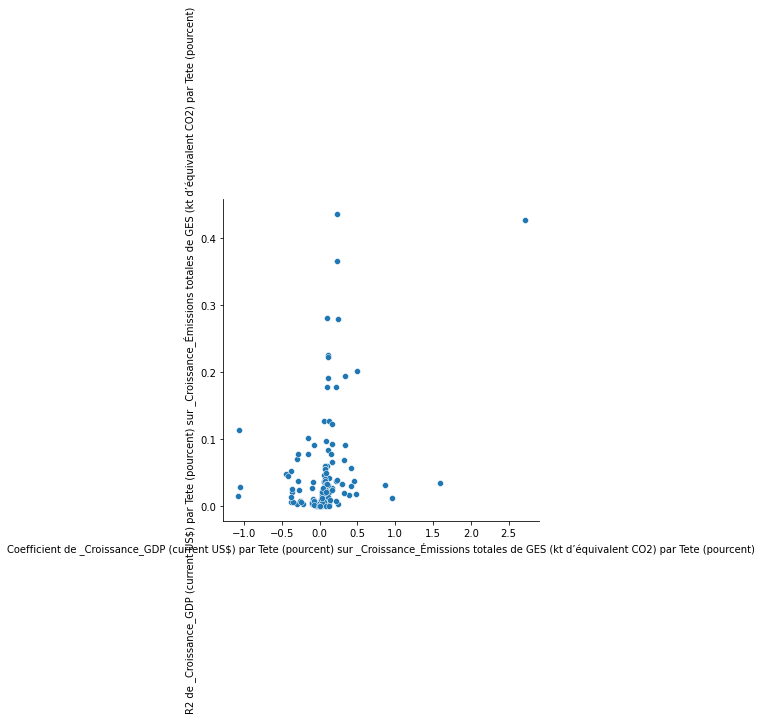

In [308]:
sns.relplot(data = data, x= 'Coefficient de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)',
            y = 'R2 de _Croissance_GDP (current US$) par Tete (pourcent) sur _Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)')